<h1> Applied Data Science Coursera Capstone </h1>

The purpose of this notebook is to accomplish the Applied Data Science Coursera Capstone requirements

In [1]:
#!jt -t oceans16 -fs 12 -ofs 12
import pandas as pd
import numpy as np

Hello Capstone Project Course!


Business Understanding - A description of the problem and a discussion of the background. 

Predict accident severity taking into account:
<ul>
    <li> Weather Conditions </li>
    <li> Road Conditions </li>
</ul>

Data Understanding - A description of the data and how it will be used to solve the problem. 

Attributes to use:
<ul>
    <li> Location </li>
    <li> Road Condition </li>
    <li> Weather Condition </li>
    <li> Junction Type </li>
    <li> Car Speeding </li>
    <li> Number of People Involved </li>
    <li> Light Conditions </li>
    <li> Number of Vehicles involved </li>
</ul>

In [2]:
df = pd.read_csv("../Data-Collisions.csv", low_memory=False)
df.head()

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

<h2> Choosing relevant variables for analysis </h2>
From the complete dataset, we will choose only the relevant variables which might have an impact in the model training.

In [4]:
colData = df[['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'COLLISIONTYPE',
               'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',  'WEATHER', 'ROADCOND', 'LIGHTCOND', 
               'SPEEDING', 'UNDERINFL', 'INATTENTIONIND']]
#Location, Road Condition, Weather Condition, Junction Type, Car Speeding, Number of People Involved, Light Conditions, Number of Vehicles involved

In [5]:
colData.head()

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,UNDERINFL,INATTENTIONIND
0,2,-122.323148,47.703140,Intersection,Angles,2,2,At Intersection (intersection related),Overcast,Wet,Daylight,NaN,N,NaN
1,1,-122.347294,47.647172,Block,Sideswipe,2,2,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,NaN,0,NaN
2,1,-122.334540,47.607871,Block,Parked Car,4,3,Mid-Block (not related to intersection),Overcast,Dry,Daylight,NaN,0,NaN
3,1,-122.334803,47.604803,Block,Other,3,3,Mid-Block (not related to intersection),Clear,Dry,Daylight,NaN,N,NaN
4,2,-122.306426,47.545739,Intersection,Angles,2,2,At Intersection (intersection related),Raining,Wet,Daylight,NaN,0,NaN


Now let's explore the data and get the frequency of each category for a given feature.

In [6]:
def list_count(columns, df):
    for col in columns:
        print(col)
        print(df[col].value_counts())
        print()

data_columns = ['SEVERITYCODE','ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 
 'ROADCOND','LIGHTCOND', 'SPEEDING', 'UNDERINFL', 'INATTENTIONIND']

#Use value_counts() method in each column
list_count(data_columns, colData)

SEVERITYCODE
1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

ADDRTYPE
Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

COLLISIONTYPE
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

JUNCTIONTYPE
Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

WEATHER
Clear                       111135
Raining                      33145
Overcast                     27714

<h2> Cleaning the Dataset </h2>
Some of the categories are not relevant or doesn't provide enough information, such as 'Unknown' or 'Other'. We should drop this kind of entries.

In [8]:
filterCond = (colData.LIGHTCOND == 'Other') | (colData.LIGHTCOND == 'Unknown') | \
                      (colData.LIGHTCOND == 'Dark - Unknown Lighting') |\
                      (colData.ROADCOND == 'Other') | (colData.ROADCOND == 'Unknown') | \
                      (colData.WEATHER == 'Other') | (colData.WEATHER == 'Unknown') | \
                      (colData.JUNCTIONTYPE == 'Other') | (colData.JUNCTIONTYPE == 'Unknown') | \
                      (colData.COLLISIONTYPE == 'Other')
colData = colData.drop(colData[filterCond].index)

Group information to uniform categories.

In [9]:
colData["LIGHTCOND"] = colData["LIGHTCOND"].replace("Dark - Street Lights Off", "Dark - No Street Lights")
colData["UNDERINFL"] = colData["UNDERINFL"].replace("N", 0)
colData["UNDERINFL"] = colData["UNDERINFL"].replace("0", 0)
colData["UNDERINFL"] = colData["UNDERINFL"].replace("1", 1)
colData["UNDERINFL"] = colData["UNDERINFL"].replace("Y", 1)
colData["INATTENTIONIND"] = colData["INATTENTIONIND"].replace("Y", 1)
colData["SPEEDING"] = colData["SPEEDING"].replace("Y", 1)

<h2> Filling missing data </h2>
We assume that if the report does not <b>explicitly</b> indicates an accident which involved driving under a alcohol/substance, then the opposite is true. We will treat the following columns as true only if the field is <b>filled</b>.

In [10]:
colData['UNDERINFL'] = colData['UNDERINFL'].fillna(0)
colData['INATTENTIONIND'] = colData['INATTENTIONIND'].fillna(0)
colData['SPEEDING'] = colData['SPEEDING'].fillna(0)

# Check the columns which has NaN values
colData.isna().sum()

SEVERITYCODE         0
X                 2609
Y                 2609
ADDRTYPE           686
COLLISIONTYPE     4898
PERSONCOUNT          0
VEHCOUNT             0
JUNCTIONTYPE      2143
WEATHER           5009
ROADCOND          4977
LIGHTCOND         5081
SPEEDING             0
UNDERINFL            0
INATTENTIONIND       0
dtype: int64

<h2> Dropping partial entries </h2>
Not all the entries or observables are complete, some of them miss relevant information which is needed to train the model.

In [11]:
colData.dropna(inplace=True)

In [12]:
colData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143741 entries, 0 to 194672
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    143741 non-null  int64  
 1   X               143741 non-null  float64
 2   Y               143741 non-null  float64
 3   ADDRTYPE        143741 non-null  object 
 4   COLLISIONTYPE   143741 non-null  object 
 5   PERSONCOUNT     143741 non-null  int64  
 6   VEHCOUNT        143741 non-null  int64  
 7   JUNCTIONTYPE    143741 non-null  object 
 8   WEATHER         143741 non-null  object 
 9   ROADCOND        143741 non-null  object 
 10  LIGHTCOND       143741 non-null  object 
 11  SPEEDING        143741 non-null  float64
 12  UNDERINFL       143741 non-null  float64
 13  INATTENTIONIND  143741 non-null  float64
dtypes: float64(5), int64(3), object(6)
memory usage: 16.4+ MB


Now that the data is cleaned.

<h2> Balancing Data </h2>
The not <i>severe collitions</i>, are most frequent than the <i>severe ones</i>. Data is unbalanced, so we will proceed to under sample it.

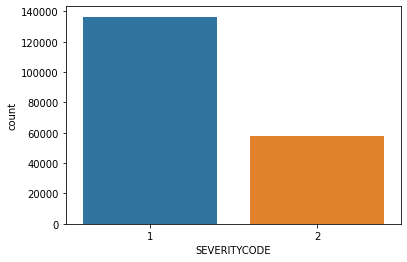

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="SEVERITYCODE", data=colData)
plt.savefig('fig/severity_count.png',dpi=300, bbox_inches = "tight")

Not severe collitions:  48923
    Severe collitions:  48923


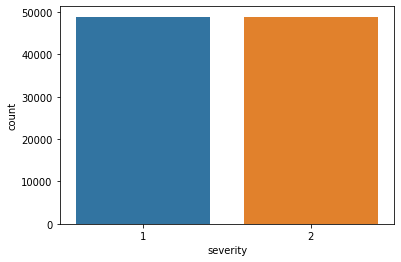

In [14]:
from imblearn.under_sampling import RandomUnderSampler

X = colData[['X', 'Y', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT',
       'VEHCOUNT', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'SPEEDING', 'UNDERINFL', 'INATTENTIONIND']]
y = colData[['SEVERITYCODE']]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
colData = X_resampled
colData['severity'] = y_resampled

severeCols = colData[colData.severity == 2]
notSevereCols = colData[colData.severity == 1]

print("Not severe collitions: ", len(severeCols))
print("    Severe collitions: ", len(notSevereCols))

sns.countplot(x="severity", data=colData)
plt.savefig('fig/severity_count_after.png',dpi=300, bbox_inches = "tight")

<h2> Analyzing variables </h2>
Now that the data is balanced, we can take a visual look to the variables to see if they are relevant to the model training.

<AxesSubplot:xlabel='count', ylabel='INATTENTIONIND'>

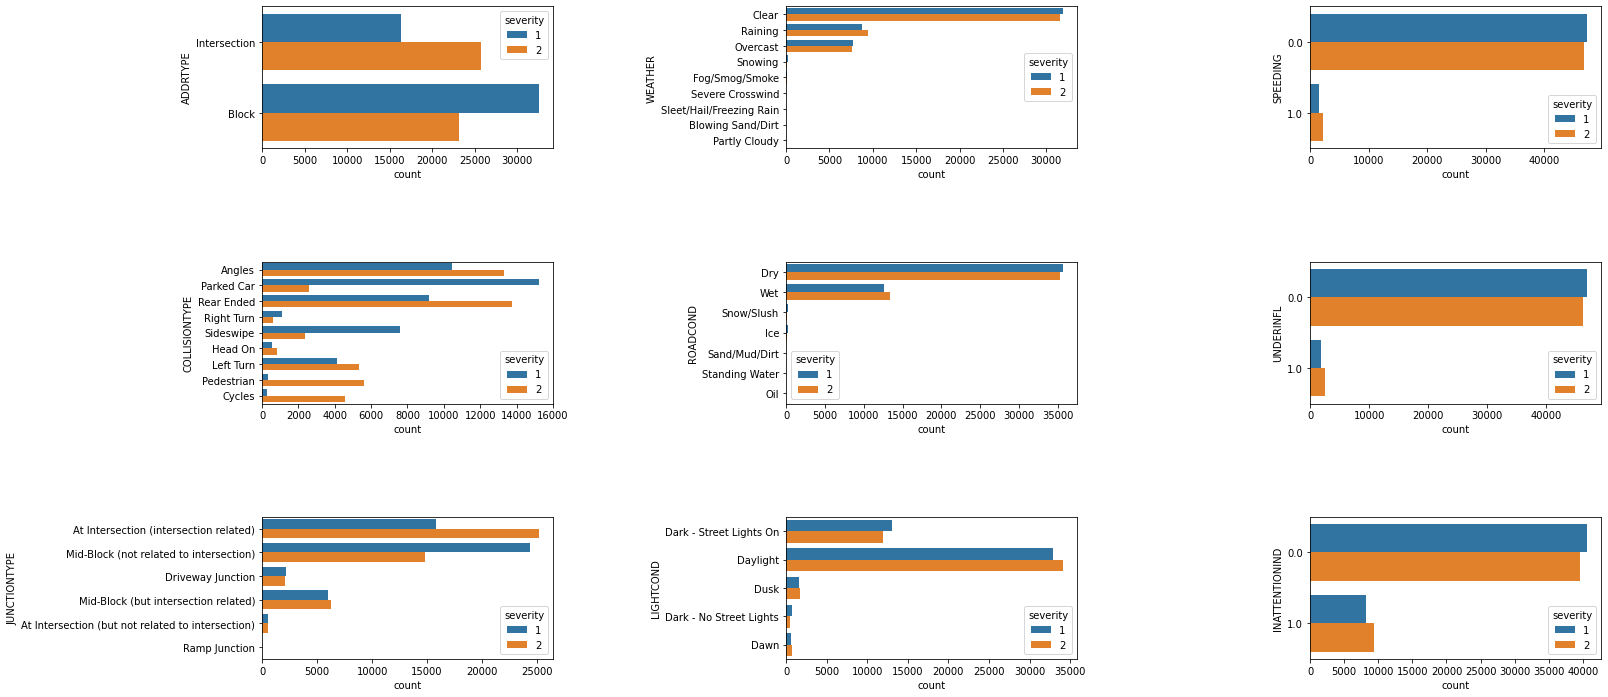

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(24,12))
plt.subplots_adjust(hspace = 0.8, wspace=0.8)
sns.countplot(y="ADDRTYPE", hue="severity", data=colData, ax=axs[0, 0])
sns.countplot(y="COLLISIONTYPE", hue="severity", data=colData, ax=axs[1, 0])
sns.countplot(y="JUNCTIONTYPE", hue="severity", data=colData, ax=axs[2, 0])
sns.countplot(y="WEATHER", hue="severity", data=colData, ax=axs[0, 1])
sns.countplot(y="ROADCOND", hue="severity", data=colData, ax=axs[1, 1])
sns.countplot(y="LIGHTCOND", hue="severity", data=colData, ax=axs[2, 1])
sns.countplot(y="SPEEDING", hue="severity", data=colData, ax=axs[0, 2])
sns.countplot(y="UNDERINFL", hue="severity", data=colData, ax=axs[1, 2])
sns.countplot(y="INATTENTIONIND", hue="severity", data=colData, ax=axs[2, 2])

/home/augusto/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Feature ADDRTYPE: 0.019765
Feature COLLISIONTYPE: 0.125225
Feature JUNCTIONTYPE: 0.028484
Feature WEATHER: 0.001333
Feature ROADCOND: 0.005442
Feature LIGHTCOND: 0.005562
Feature SPEEDING: 0.000000
Feature UNDERINFL: 0.002487
Feature INATTENTIONIND: 0.000829


<AxesSubplot:>

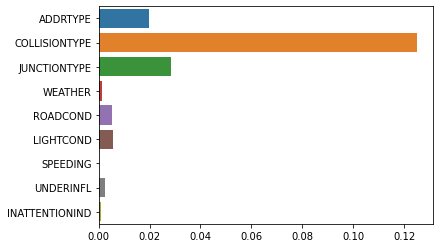

In [16]:
# example of mutual information feature selection for categorical data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
 
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def calc_entropy(X, y, n):
    scores = []
    result = np.zeros(len(X.columns))
    
    for i in range(n):
        # split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
        # prepare input data
        X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
        # prepare output data
        y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
        # feature selection
        X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
        # what are scores for the features
        result = fs.scores_ + result
        
    return result / n

X = X_resampled
X = X.drop(columns=['X','Y', 'PERSONCOUNT', 'VEHCOUNT', 'severity'])
X = X.astype(str)
y = y_resampled

iterations = 1

result = calc_entropy(X, y, iterations)

for i in range(len(result)):
    print('Feature %s: %f' % (X.columns[i], result[i]))
# Plot the scores

sns.barplot(y=X.columns, x=result)
#plt.savefig('fig/feature_extraction.png',dpi=300, bbox_inches = "tight")

Finally, let's take a look at the variables we drop before the mutual information analysis.

<AxesSubplot:xlabel='PERSONCOUNT', ylabel='count'>

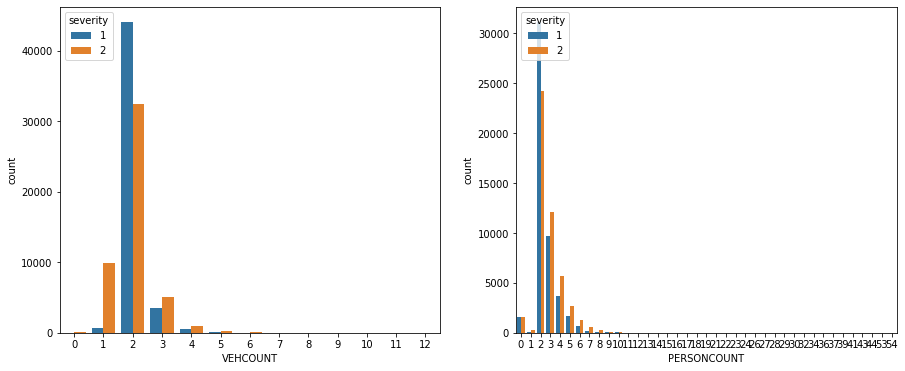

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(15,6))
sns.countplot(x="VEHCOUNT", hue="severity", data=colData, ax=axs[0])
sns.countplot(x="PERSONCOUNT", hue="severity", data=colData, ax=axs[1])

Script lines to save plots as png files.

<AxesSubplot:xlabel='count', ylabel='COLLISIONTYPE'>

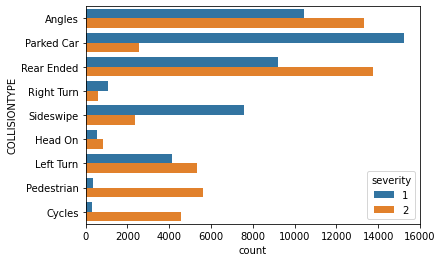

In [19]:
sns.countplot(y="COLLISIONTYPE", hue="severity", data=colData)
#plt.savefig('fig/collisions.png',dpi=300, bbox_inches = "tight")
sns.countplot(y="JUNCTIONTYPE", hue="severity", data=colData)
#plt.savefig('fig/junction.png',dpi=300, bbox_inches = "tight")
fig, axs = plt.subplots(ncols=2, figsize=(18,6))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x="VEHCOUNT", hue="severity", data=colData, ax=axs[0])
sns.countplot(x="PERSONCOUNT", hue="severity", data=colData, ax=axs[1])
fig.get_axes()[1].legend(loc='upper right', title='severity') 
#fig.savefig('fig/veh_person_count.png',dpi=300, bbox_inches = "tight")

# Geolocation Analysis
In order to locate the frequency of the collisions in a given zone, let's take a look using folium clusters.

In [18]:
"""
import folium
from folium import plugins

latitude = colData.Y.mean()
longitude = colData.X.mean()

# create map and display it
seattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
collisions = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(colData.Y, colData.X, colData.severity):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(collisions)

# display map
seattle_map
"""

'\nimport folium\nfrom folium import plugins\n\nlatitude = colData.Y.mean()\nlongitude = colData.X.mean()\n\n# create map and display it\nseattle_map = folium.Map(location=[latitude, longitude], zoom_start=12)\n\n# instantiate a mark cluster object for the incidents in the dataframe\ncollisions = plugins.MarkerCluster().add_to(seattle_map)\n\n# loop through the dataframe and add each data point to the mark cluster\nfor lat, lng, label, in zip(colData.Y, colData.X, colData.severity):\n    folium.Marker(\n        location=[lat, lng],\n        icon=None,\n        popup=label,\n    ).add_to(collisions)\n\n# display map\nseattle_map\n'

# Structuring data to train the model

We need to perform some actions before training the model:
    - Rename severity to 0,1
    - Select relevant feature set
    - Convert them to one hot enconding
    - Normalize and split data
    
Let's get started

<AxesSubplot:xlabel='severity', ylabel='count'>

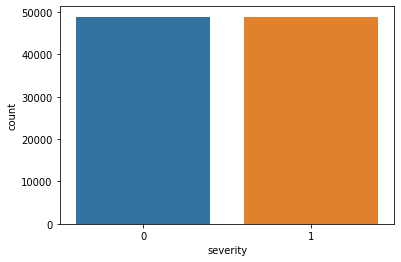

In [23]:
# Rename severity to 0,1
colData["severity"] = colData["severity"].replace(1, 0)
colData["severity"] = colData["severity"].replace(2, 1)
sns.countplot(x="severity", data=colData)

In [30]:
# One hot encoding for the relevant dataset
feature = pd.concat([pd.get_dummies(colData['WEATHER']), 
                     pd.get_dummies(colData['ROADCOND']),
                     pd.get_dummies(colData['LIGHTCOND'])], axis=1)
feature.head()

,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Partly Cloudy,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Dry,...,Oil,Sand/Mud/Dirt,Snow/Slush,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights On,Dawn,Daylight,Dusk
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [35]:
# Defining X matrix and y vector
X = feature
y = colData['severity'].values

In [36]:
# Normalizing and splitting data
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (78276, 21) (78276,)
Test set: (19570, 21) (19570,)


# K-Nearest Neighbour Classification Method

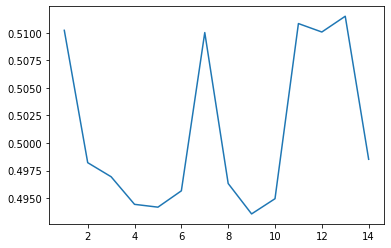

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Best k
Ks=15
accuracy = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    accuracy[n-1] = accuracy_score(y_test, yhat)


plt.plot(range(1,Ks), accuracy)

Given the result, the best k value is 7 which also prevents overfitting. Let's re-traing KNN with neighbours = 7 and get the accuracy score.

In [48]:
kNN_model = KNeighborsClassifier(n_neighbors=7).fit(X_train,y_train)
yhat = kNN_model.predict(X_test)
print(accuracy_score(y_test, yhat))

0.5100153295861012


# Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

# Train to the maximum depth
#DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 7)

DT_model = DecisionTreeClassifier(criterion="entropy")
DT_model.fit(X_train,y_train)
yhat = DT_model.predict(X_test)

print(accuracy_score(y_test, yhat))

0.5194174757281553


# Support Vector Machine

In [50]:
from sklearn import svm

SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train)
yhat = SVM_model.predict(X_test)

print(accuracy_score(y_test, yhat))

0.5194685743484926


# Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat = LR_model.predict(X_test)

print(accuracy_score(y_test, yhat))

0.5183444047010731


# Random Forest 

In [83]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier().fit(X_train,y_train)
yhat = RF_model.predict(X_test)

print(accuracy_score(y_test, yhat))

0.5197240674501789


In [84]:
# Let's save the models for later use (to avoid retrain KNN and SVM)
import pickle
models = {'KNN_model': kNN_model, 'DT_model': DT_model, 'SVM_model': SVM_model, 
          'LR_model': LR_model, 'RF_model': RF_model}

for filename, model in models.items():
    pickle.dump(model, open('models/{}.mdl'.format(filename), 'wb'))

In [62]:
# Retrieve models from HDD
for filename, model in models.items():
    model = pickle.load(open('models/{}.mdl'.format(filename), 'rb'))
    
yhat = LR_model.predict(X_test)
print(accuracy_score(y_test, yhat))

0.5183444047010731


In [80]:
from sklearn.metrics import jaccard_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#print(confusion_matrix(y_test, yhat, labels=[1,0]))

In [81]:
def get_scores(name, y_test, yhat):
    print("Evaluation of {} model".format(name))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['severity=1','severity=0'],
                          normalize= False,  title='{} confusion matrix'.format(name))

    print(classification_report(y_test, yhat))
    print("Accuracy score: %.2f" % accuracy_score(y_test, yhat))
    print("Jaccard score: %.2f" % jaccard_score(y_test, yhat))
    print("f1-score: %.2f" % f1_score(y_test, yhat, average='weighted'))

Evaluation of KNN_model model
              precision    recall  f1-score   support

           0       0.51      0.43      0.46      9693
           1       0.51      0.59      0.55      9877

    accuracy                           0.51     19570
   macro avg       0.51      0.51      0.51     19570
weighted avg       0.51      0.51      0.51     19570

Accuracy score: 0.51
Jaccard score: 0.38
f1-score: 0.51
-------------------------
Evaluation of DT_model model
              precision    recall  f1-score   support

           0       0.53      0.24      0.33      9693
           1       0.52      0.79      0.62      9877

    accuracy                           0.52     19570
   macro avg       0.52      0.52      0.48     19570
weighted avg       0.52      0.52      0.48     19570

Accuracy score: 0.52
Jaccard score: 0.45
f1-score: 0.48
-------------------------
Evaluation of SVM_model model
              precision    recall  f1-score   support

           0       0.53      0.24     

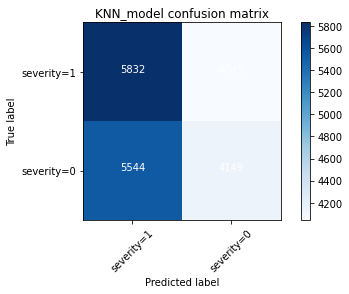

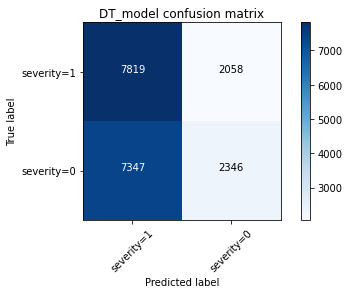

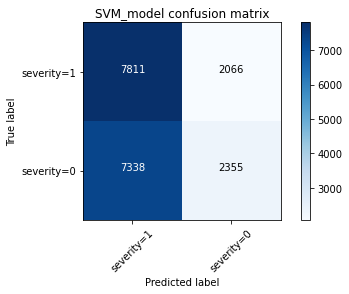

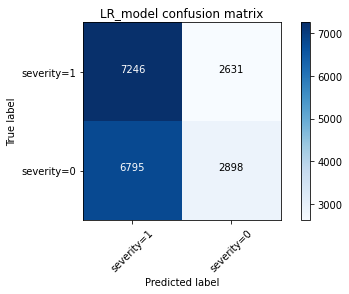

In [82]:
for filename, model in models.items():
    yhat = model.predict(X_test)
    get_scores(filename, y_test, yhat)
    print("-------------------------")

# Optimization

Based on the results, let's optimize the Logistic Regression and Random Forest Models

In [96]:
# Create first pipeline for base without reducing features.
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['lbfgs']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(75,85,1)),
    'classifier__max_features' : list(range(6,16,1))}
]

# Create grid search object

model = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_model = model.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 28.0min finished


{'classifier': RandomForestClassifier(max_features=6, n_estimators=75), 'classifier__max_features': 6, 'classifier__n_estimators': 75}
Evaluation of Best Model model
              precision    recall  f1-score   support

           0       0.53      0.24      0.33      9693
           1       0.52      0.79      0.63      9877

    accuracy                           0.52     19570
   macro avg       0.52      0.52      0.48     19570
weighted avg       0.52      0.52      0.48     19570

Accuracy score: 0.52
Jaccard score: 0.45
f1-score: 0.48


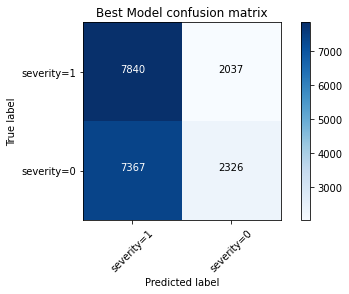

In [99]:
print(best_model.best_params_)
yhat = best_model.predict(X_test)
get_scores('Best Model', y_test, yhat)

In [98]:
best_model.best_params_

{'classifier': RandomForestClassifier(max_features=6, n_estimators=75),
 'classifier__max_features': 6,
 'classifier__n_estimators': 75}

In [100]:
pickle.dump(best_model, open('models/{}.mdl'.format('RF_optimized'), 'wb'))